<a href="https://colab.research.google.com/github/apothula/dl/blob/main/Seg/01_Introduction_to_Segmentation_Datasets_and_Custom_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Introduction to Segmentation Datasets and Custom Data Loader</h1>

In this notebook, we will review three different semantic segmentation datasets that we will use in this module. Along with that, we will also see how to create a **custom data loader** using TensorFlow's `Sequence` class which can be used to easily create dataset objects for training and validation. This is important because Tensorflow does not have a standard method for loading segmentation datasets.

<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-SUIM-feature-image.png" width=1000>

## Table of Contents

* [1 Semantic Segmentation Datasets](#1-Semantic-Segmentation-Datasets)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Custom Data Loader for Semantic Segmentation](#3-Custom-Data-Loader-for-Semantic-Segmentation)
* [4 Utilities and Helper Functions](#4-Utilities-and-Helper-Functions)
* [5 Using the Custom Data Loader Class](#5-Using-the-Custom-Data-Loader-Class)
* [6 Conclusion](#6-Conclusion)

## 1 Semantic Segmentation Datasets

In the next few notebooks, we will be using three different datasets for semantic segmentation. Let's take a look at them briefly here.

### 1.1 KITTI Road Segmentation Dataset

The <a href="http://www.cvlibs.net/datasets/kitti/eval_road.php" target="_blank">KITTI Road Segmentation dataset</a> contains images of roads and their corresponding masks from real-life driving scenarios. This dataset is used to segment the main road from the rest of the image. The ground truth masks in this dataset contain up to three colors which represent the main road (pink), any secondary roads/lanes (black), and the background (red). For our purposes, we will treat this as a **binary segmentation dataset with two classes** and will pre-process the image masks so that any black regions are included in the background class.

As with any segmentation dataset, the colors used to represent the classes are arbitrary and only serve the purpose that there is a unique mapping from classes to colors, but we need to know what the mapping is so we can properly process the data and interpret the segmentation predictions.

Excluding classes from the dataset or changing the colors for the classes can be easily accomplished with a dictionary that maps class IDs to colors. This will be demonstrated in the next notebook.

<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-kitti-road-dataset-training-sample.png" width=800>

### 1.2 CamVid Dataset

The <a href="http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/" target="_blank">CamVid (Cambridge-driving Labeled Video Database)</a> is a driving and scene understanding dataset containing images extracted from five video sequences taken during real-world driving scenarios. The dataset contains 32 classes.

<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-camvid-dataset-training-samples.png" width=900>

The following image shows the percentage of each class that was present in the original dataset with the segmentation color used for each class.

<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-camvid-class-percentage.png" width=600>

### 1.3 Semantic Segmentation of Underwater Imagery (SUIM)  Dataset

The Semantic Segmentation of Underwater Imagery (SUIM) <a href="https://irvlab.cs.umn.edu/resources/suim-dataset" target="_blank">dataset</a> is an underwater dataset developed at the University of Minnesota.

<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-SUIM-6classes.png" width=1000 align=center>

The dataset contains images of from eight object classes as follows:

<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-SUIM-8class-table.png" width=500 align=center>
    
As noted in the original research paper <a href="https://arxiv.org/pdf/2004.01241.pdf" target="_blank">SUIM Dataset and Benchmark</a> semantic segmentation was performed using six of the eight classes as shown in the table below, which assumes the aquatic plants and flora and sea-floor and rocks are all part of the background (waterbody) class. We have not modified the ground truth masks for this purpose since this can be achieved by defining a smaller color mapping dictionary for the six classes below. We'll see how this is done further below in this notebook.


<img src="https://opencv.org/wp-content/uploads/2022/07/c4-05-SUIM-6class-table.png" width=500 align=center>


In [1]:
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import zipfile
import requests
import albumentations as A
import cv2
import os

from tensorflow.keras.utils import Sequence
from dataclasses import dataclass

## 2 Download and Extract the SUIM Dataset

We'll first start by downloading and extracting the SUIM dataset.

In [2]:
# To Download processed dataset.
def download_file(url, save_name):
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)

In [3]:
# To Unzip the dataset file.
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [4]:
save_name = "dataset_SUIM.zip"

if not os.path.exists(save_name):
    download_file(
        'https://www.dropbox.com/s/1g2y2nu9v7gizu9/dataset_SUIM.zip?dl=1',
        save_name
    )

    unzip(zip_file=save_name)

Extracted all


The dataset has the following file structure.
```
dataset_SUIM/

    ├── test
    │   ├── images [110 samples]
    │   └── masks  [110 samples]
    ├── train
    │   ├── images [1220 samples]
    │   └── masks  [1220 samples]
    └── valid
        ├── images [305 samples]
        └── masks  [305 samples]
```

### 2.1 Dataset Configurations

Here we define a few parameters associated with the dataset. The size of most images (and masks) in the dataset is  512 x 384, but in the example below, we will resize the images to be 256 x 256. As we will see in subsequent notebooks, we can achieve better results by using higher resolution images, but this also increases the time required to train the model.

In [5]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 6
    IMG_WIDTH:   int = 256
    IMG_HEIGHT:  int = 256
    DATA_TRAIN_IMAGES: str = 'dataset_SUIM/train/images/*.jpg'
    DATA_TRAIN_LABELS: str = 'dataset_SUIM/train/masks/*.bmp'
    DATA_VALID_IMAGES: str = 'dataset_SUIM/valid/images/*.jpg'
    DATA_VALID_LABELS: str = 'dataset_SUIM/valid/masks/*.bmp'
    DATA_TEST_IMAGES:  str = 'dataset_SUIM/test/images/*.jpg'
    DATA_TEST_LABELS:  str = 'dataset_SUIM/test/masks/*.bmp'

## 3 Custom Data Loader for Semantic Segmentation

The data processing pipeline required for semantic segmentation differs quite a bit compared to image classification. In semantic segmentation, the labels mask are also images, represented as segmentation masks of the ground truth, where every pixel in the mask is assigned to a unique class. We cannot use any pre-defined data loader method or class from TensorFlow to process the dataset ground truth masks. We, therefore, need to write our own custom dataset loader by subclassing the `Sequence` class. In this notebook, we will demonstrate how to use a custom data loader class to load and visualize the Aerial Satellite Imagery dataset.

### 3.1 Custom Data Loader Class

In the code cell below, we define the `CustomSegDataLoader` class, which is a subclass of the `Sequence` class. In defining this custom class we are going to override three of the so-called "dunder" (for double underscore) methods for our own purposes: `__init__`, `__len__`, and `__getitem__` methods. Along with those, we can also include our own custom methods as needed to implement the rest of the class. In the section that follows, we will review each of these methods and their purpose.

In [6]:
# Custom Class for creating training and validation (segmentation) dataset objects.
class CustomSegDataLoader(Sequence):

    def __init__(self, batch_size, image_size, image_paths, mask_paths, num_classes, aug):

        self.batch_size  = batch_size
        self.image_size  = image_size
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.num_classes = num_classes
        self.aug = aug

        self.x = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
        self.y = np.empty((self.batch_size,) + self.image_size, dtype="float32")

        if self.aug:
            self.train_transforms = self.transforms()

        self.resize_transforms = self.resize()

    def __len__(self):

        return len(self.mask_paths) // self.batch_size

    def transforms(self):

        # Data augmentation.
        train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0.2,
                               shift_limit=0.2, p=0.5, border_mode=0),
        ])
        return train_transforms

    def resize(self):

        resize_transforms = A.Resize(
            height=self.image_size[0], width=self.image_size[1],
            interpolation=cv2.INTER_NEAREST,
            always_apply=True, p=1
        )
        return resize_transforms

    def reset_array(self):
        self.x.fill(0.)
        self.y.fill(0.)

    def __getitem__(self, idx):
        self.reset_array()
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i : i + self.batch_size]
        batch_mask_paths = self.mask_paths[i : i + self.batch_size]

        for j, (input_image, input_mask) in enumerate(zip(batch_image_paths, batch_mask_paths)):

            # Read the image and convert to RGB.
            img = cv2.imread(input_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Read the mask and convert to RGB.
            msk = cv2.imread(input_mask)
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

            # Resize the image and mask.
            resized  = self.resize_transforms(image=img, mask=msk)
            img, msk = resized['image'], resized['mask']

            if self.aug:
                # Apply augmentations.
                train_augment = self.train_transforms(image=img, mask=msk)
                img, msk = train_augment['image'], train_augment['mask']

            # Store image in x.
            self.x[j] = img / 255. # Normalizing image to be in range [0.0, 1.0]

            # Convert RGB segmentation mask to multi-channel (one-hot) encoded arrays where
            # each channel represents a single class whose pixel values are either 0 or 1,
            # where a 1 represents a pixel location associated with the class that corresponds
            # to the channel.
            msk = rgb_to_onehot(msk)

            # Convert the multi-channel (one-hot encoded) mask to a single channel (grayscale)
            # representation whose values contain the class IDs for each class (essentially
            # collapsing the one-hot encoded arrays into a single channel).
            self.y[j] = msk.argmax(-1)

        return self.x, self.y

###  `__init__()`
In the `__init__()` method, we initialize all the variables we need in the entire class for preparing the dataset. This includes the input image paths (`image_paths`) and input segmentation masks (`mask_paths`) which are the lists containing the paths to all the images and masks. Along with that, we define the batch size, image size, and the number of classes as well. Note that the number of classes is not specifically used but is a good attribute to include in the class as a reference.

The two NumPy arrays `x` and `y` are used to store the images of shape `[HEIGHT, WIDTH, 3]` and masks of shape `[HEIGHT, WIDTH]`.

###  `__len__()`  
The  `__len__()` method returns the number of data batches (number of data samples divided by the batch size).

### `transforms()`
The `transforms()` method contains all the augmentations that we want to apply to the images and masks. It returns a container of transformation functions to be applied sequentially.

### `resize()`
The `resize()` method returns the `resize_transforms` function to resize the images and masks to the same dimensions..

### `reset_array()`
The `reset_array()` method is used to fill the `x` and `y` NumPy arrays with zeros so that the arrays are ready to store a new batch of data before the next iteration begins.

###  `__getitem__()`
In the `__getitem__()` method, the value of the `idx` argument keeps increasing. So, on the first iteration, the value is 0, on the second iteration, it is 1, and so on.

In the `for` loop, we iterate over the elements (image and mask paths) present in the current `batch_input_imgpaths` and `batch_target_imgpaths`. We read the images and the masks and apply the required preprocessing, which includes resizing and augmentations.

Then we convert the mask to a one-hot encoded format. We store the current image and mask in the `x` and `y` NumPy arrays. ***But observe that we are converting the masks to grayscale images using `argmax()` and then storing those in `y`***.

## 4 Utilities and Helper Functions

In this section, we define several utilities and helper functions that will be used further below. We start by creating a dictionary mapping from the class ID to the RGB colors used to render the predicted segmentation map.

In [7]:
id2color = {
    0: (0,  0,    0),    # BW: Background/waterbody
    1: (0,  0,    255),  # HD: Human divers
    2: (0,  255,  255),  # WR: Wrecks and ruins
    3: (255, 0,   0),    # RO: Robots and instruments
    4: (255, 0,   255),  # RI: Reefs and invertebartes
    5: (255, 255, 0),    # FV: Fish and vertebrates
 }

When preparing the masks in the custom data loader class, we need to convert the RGB images to one-hot encoded images where the number of channels will be the same as the number of channels (classes) in the dataset. The following function performs this conversion.

In [8]:
# Function to one-hot encode RGB mask labels.
def rgb_to_onehot(rgb_arr, color_map=id2color, num_classes=DatasetConfig.NUM_CLASSES):

    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )

    for i, classes in enumerate(color_map):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])

    return arr

The following function will be used to convert single-channel mask representations to an integrated RGB mask for visualization purposes.

In [9]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):

    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[single_layer==k] = color_map[k]

    return np.float32(output) / 255. # return a floating point array in range [0.0, 1.0]

Helper function to overlay an RGB segmentation map on top of an RGB image.

In [10]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return np.clip(image, 0.0, 1.0)

The convenience function below will display the original image, the ground truth mask, and the ground truth mask overlayed on the original image. Note that there is an optional argument that allows you to control if the ground truth mask is displayed as a grayscale image or a color image.

In [11]:
def display_image_and_mask(data_list, color_mask=False, color_map=id2color):

    plt.figure(figsize=(16, 6))
    title = ['GT Image', 'GT Mask', 'Overlayed Mask']

    grayscale_gt_mask = data_list[1]

    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)

    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], rgb_gt_mask)

    data_list.append(overlayed_image)

    for i in range(len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        if title[i] == 'GT Mask':
            if color_mask:
                plt.imshow(np.array(rgb_gt_mask))
            else:
                plt.imshow(np.array(grayscale_gt_mask))
        else:
            plt.imshow(np.array(data_list[i]))
        plt.axis('off')

    plt.show()

## 5 Using the Custom Data Loader Class

Here we define the `create_datasets()` function used below to generate training and validation dataset objects for the Aerial imagery dataset. Notice that the augmentation flag for the validation dataset is explicitly set to `False` since data augmentation should only be an option for the training dataset.

In [12]:
def create_datasets(aug=False):

    # Training image and mask paths.
    train_images = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_IMAGES}"))
    train_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_LABELS}"))

    # Validation image and mask paths.
    valid_images = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_IMAGES}"))
    valid_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_LABELS}"))

    # Train data loader.
    train_ds = CustomSegDataLoader(batch_size=8,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=train_images,
                                   mask_paths=train_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=aug,
                                  )
    # Validation data loader.
    valid_ds = CustomSegDataLoader(batch_size=8,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=valid_images,
                                   mask_paths=valid_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=False,
                                  )

    return train_ds, valid_ds

Now we call the above function to create the dataset objects and notice that the augmentation flag is set to `True`, but is only applied to the training dataset in the function above.

In [13]:
train_ds, valid_ds = create_datasets(aug=True)

### 5.1 Display Sample Images from the Dataset

In the code cell below, we loop over the first three data batches in the validation dataset and display the last image in each batch, the associated ground truth mask, and the ground truth mask overlayed on the original image. The overlay helps us better visualize the segmented classes in the context of the original image.

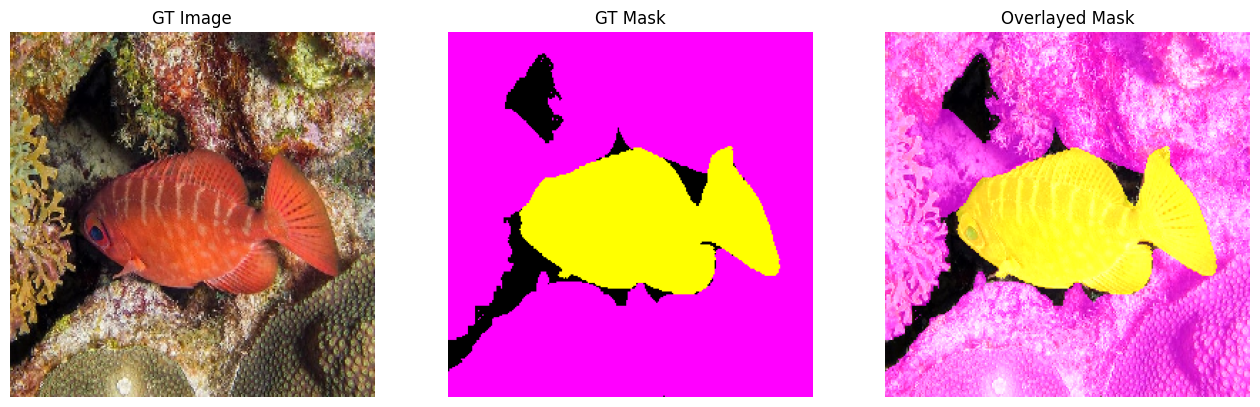

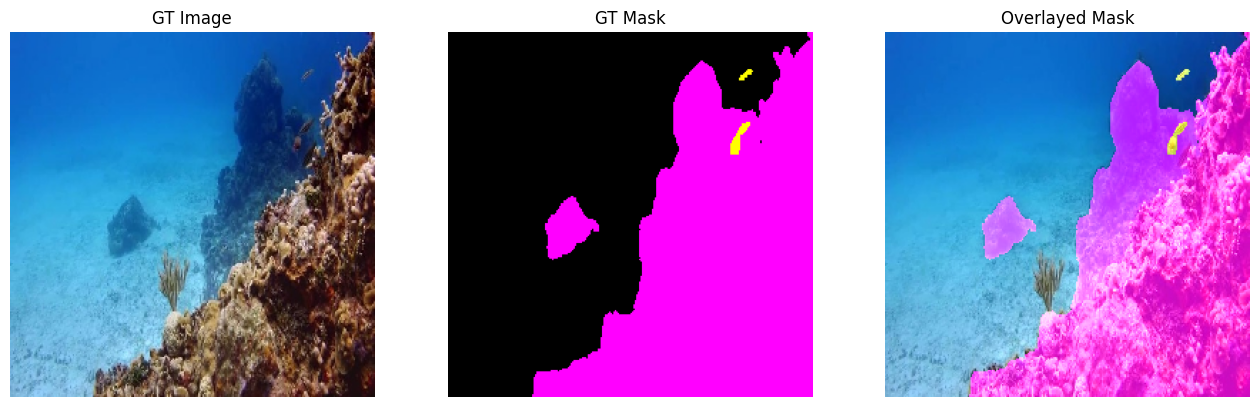

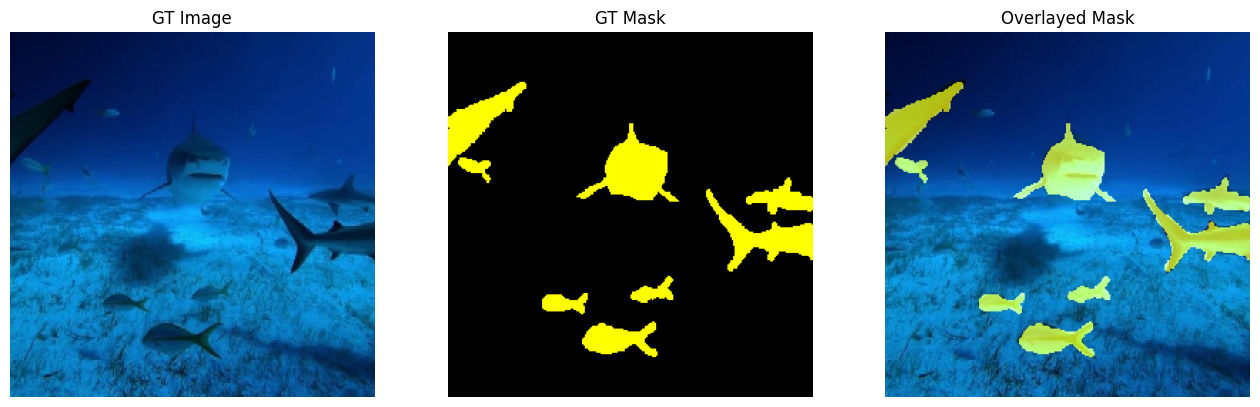

In [14]:
for i, (images, masks) in enumerate(valid_ds):
    if i == 3:
        break
    # Retrieve last image in data batch as an example.
    image, mask = images[-1], masks[-1]
    display_image_and_mask([image, mask], color_mask=True)

## 6 Conclusion

In this notebook, we reviewed the three datasets we will be using in this module to perform semantic segmentation. We also developed a **custom data loader class** that we will use throughout this module to create dataset objects that are specifically prepared for processing through semantic segmentation models.